# Setup

## imports

In [2]:
import pandas as pd
import os
from pandasql import sqldf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import boto3

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

pysqldf = lambda q: sqldf(q, globals())

# load data

In [3]:
tracking2020 = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/tracking2020.csv')
tracking2019 = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/tracking2019.csv')
tracking2018 = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/tracking2018.csv')
tracking = tracking2020.append(tracking2019).append(tracking2018)
tracking.head(3) 

# # 3 minutes

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2021-01-03T18:03:02.200,61.21,46.77,0.08,0.13,0.01,186.21,144.73,None,42901.0,Dean Marlowe,31.0,SS,home,1,2021010300,40,left
1,2021-01-03T18:03:02.300,61.22,46.77,0.11,0.19,0.01,184.87,126.09,None,42901.0,Dean Marlowe,31.0,SS,home,2,2021010300,40,left
2,2021-01-03T18:03:02.400,61.23,46.76,0.10,0.18,0.01,183.38,108.95,None,42901.0,Dean Marlowe,31.0,SS,home,3,2021010300,40,left


In [4]:
play_detail = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/plays.csv'); play_detail.head(2)

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,"J.Elliott kicks 65 yards from PHI 35 to end zone, Touchback.",1,0,0,PHI,Kickoff,Touchback,44966.0,NaN,NaN,PHI,35,15:00:00,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18


In [5]:
labels = play_detail.query('specialTeamsPlayType == "Kickoff" & specialTeamsResult == "Return"')[['gameId', 'playId', 'playResult']]
labels['fname'] = labels.apply(lambda row: str(row.gameId) + '_' + str(row.playId) + '.png', axis=1)
labels['label'] = labels.apply(lambda row: 1 if row.playResult < 30 else 0 , axis=1)
labels.head()

,gameId,playId,playResult,fname,label
3,2018090600,677,34,2018090600_677.png,0
9,2018090600,1606,60,2018090600_1606.png,0
24,2018090900,36,45,2018090900_36.png,0
26,2018090900,400,33,2018090900_400.png,0
39,2018090900,1992,40,2018090900_1992.png,0


In [6]:
labels.label.sum()
   

405

In [14]:
len(labels)

2921

# simulating individual plays

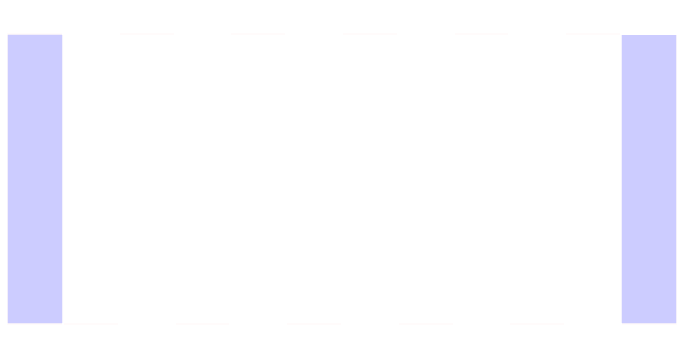

In [7]:
def create_football_field(linenumbers=False,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='white', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

In [8]:
def plot_presnap_alignment(df, gameId, playId):
    example_play_home = tracking2020.query(f'gameId == {gameID} and playId == {playId} and team == "home"')
    example_play_away = tracking2020.query(f'gameId == {gameID} and playId == {playId} and team == "away"')

    fig, ax = create_football_field()
    example_play_home.query('event == "ball_snap"').plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
    example_play_away.query('event == "ball_snap"').plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
    plt.title(f'Game {gameID} Play {playId} at Ball Snap')
    plt.legend()
    plt.show()


No handles with labels found to put in legend.


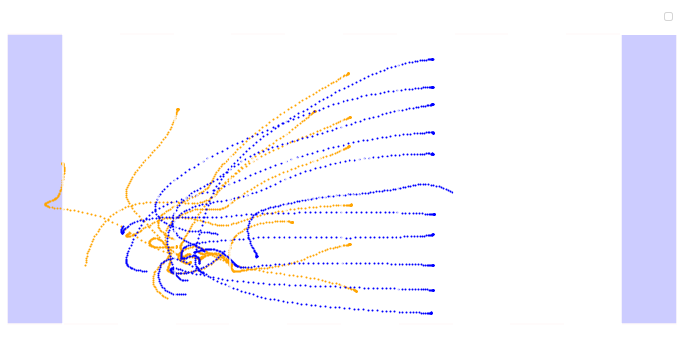

In [ ]:
example_play_home = tracking.query('gameId == 2021010300 and playId == 395 and team == "home"')
example_play_away = tracking.query('gameId == 2021010300 and playId == 395 and team == "away"')

fig, ax = create_football_field()
example_play_home.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
example_play_away.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
plt.legend()
plt.show()


No handles with labels found to put in legend.


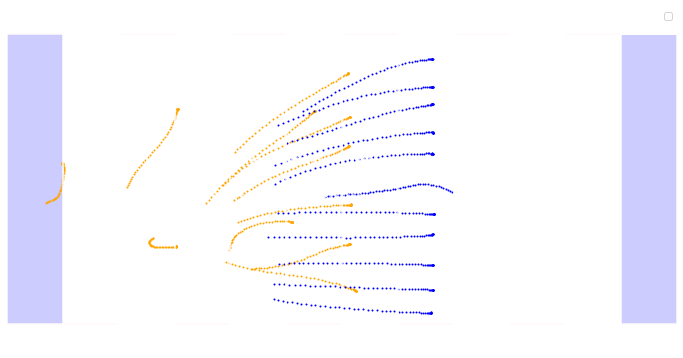

In [18]:
# plot the first X frames

example_play_home = tracking.query('gameId == 2021010300 and playId == 395 and team == "home" and frameId < 50')
example_play_away = tracking.query('gameId == 2021010300 and playId == 395 and team == "away" and frameId < 50')

fig, ax = create_football_field()
example_play_home.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
example_play_away.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
plt.legend()
plt.show()


# generate photo dataset

In [11]:
distinct_playIds = pysqldf("""SELECT distinct gameId, playId from labels""")

In [12]:
for gameId, playId in distinct_playIds.itertuples(index=False):
    home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home" and frameId < 30')
    away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away" and frameId < 30')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v2_frame_sub30/{filename}')
    plt.close('all')

In [13]:
for gameId, playId in distinct_playIds.itertuples(index=False):
    home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home" and frameId < 40')
    away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away" and frameId < 40')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v2_frame_sub40/{filename}')

/var/folders/lj/g01_5tgs38z2t4_x54wpk5z00000gq/T/ipykernel_2759/1106490841.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=figsize)


In [23]:
for gameId, playId in distinct_playIds.itertuples(index=False):
    home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home" and frameId < 50')
    away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away" and frameId < 50')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v2_frame_sub50/{filename}')

/var/folders/lj/g01_5tgs38z2t4_x54wpk5z00000gq/T/ipykernel_10121/1106490841.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, figsize=figsize)


In [ ]:
for gameId, playId in distinct_playIds.itertuples(index=False):
    home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home" and frameId < 60')
    away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away" and frameId < 60')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v2_frame_sub60/{filename}')

In [ ]:
for gameId, playId in distinct_playIds.itertuples(index=False):
    home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home" and frameId < 70')
    away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away" and frameId < 70')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v2_frame_sub70/{filename}')

In [8]:
for gameId, playId in [[2018090600,	677]]:
    home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home" and frameId < 30')
    away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away" and frameId < 30')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/test/{filename}')
    plt.close('all')